# Prueba para joint 7 con movimiento sinusoidal frecuencia constante
## Coding
### Importando librerías


In [1]:
#importing all libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from numpy.linalg import inv
from numpy import matmul as mx

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
class states():
    def __init__(self):
        self.p = []
        self.v = []
        self.a = []
        
        self.x_k_k = np.zeros((3,1))
        self.x_k1_k = np.zeros((3,1))
        
        self.P_k_k =  np.eye(3) #np.random.randn(3,3)
        self.P_k1_k = np.eye(3) #np.random.randn(3,3)
        
        self.K = np.random.randn(3,2)
        
        self.Q = 0.0004*np.eye(3)#np.diag(np.random.randn(1,3)[0,:])#np.eye(3)
        self.R = 0.002*np.eye(2)#np.diag(np.random.randn(1,2)[0,:])
        self.I = np.eye(3)
        
        #self.q_t = []
        #self.F = np.array([])
        #self.G = np.array([])
        #self.H = np.array([])
        
    def kalman_filter(self, pos_v, vel_v):
        # Sort data
        z = []
        for pos, vel in zip(pos_v, vel_v):
            #print pos, vel
            z.append([pos, vel])
        z = np.array(z)
        F = np.array([])
        H = np.array([])
        
        
        # Matrix model
        T_ = 0.1
        
        F = np.array([[1., T_, T_**2],[0., 1., T_],[0.,0.,1.]])
        H = np.array([[1., 0., 0.],[0., 1., 0.]])
        for z_med in z:
            #Prediction
            self.x_k1_k = mx(F,self.x_k_k)
            self.P_k1_k = mx(F, mx(self.P_k_k, np.transpose(F))) +  self.Q

            #Update
            self.x_k_k = self.x_k1_k + mx(self.K, (z_med.reshape(2,1) - mx(H, self.x_k1_k)))
            self.P_k_k = mx(mx((self.I - mx(self.K, H)), self.P_k1_k), np.transpose(self.I - mx(self.K, H))) +mx(self.K, mx(self.R, np.transpose(self.K))) 

            self.K = mx(mx(self.P_k1_k, np.transpose(H)), inv(mx(H, mx(self.P_k1_k, np.transpose(H))) + self.R))   
            self.p.append(self.x_k_k[0][0])
            self.v.append(self.x_k_k[1][0])
            self.a.append(self.x_k_k[2][0])


## Loading data

In [20]:
df = pd.read_csv('training_data_random.csv')#('training_data_05.csv')
df_val = pd.read_csv('validation_data_random.csv')

# Define datos
joint_name = 'j4'
joint_desired_name = 'jd4'
effort_desired_name = 'e4'
velocity_name = 'v4'

joint = df[joint_name]
joint_desired = df[joint_desired_name]
effort_desired = df[effort_desired_name]
velocity = df[velocity_name]

inicio = 3000
final = 7000

joint7_train = states()
joint7_train.kalman_filter(joint, velocity)

# x_train, y_train
(number_training_data, _) = df.shape
q_tmp = df[joint_name].values.reshape(number_training_data,1)
T_tmp = df[effort_desired_name].values.reshape(number_training_data,1)
v_tmp = df[velocity_name].values.reshape(number_training_data,1)
qd_tmp = df[joint_desired_name]
joint7_train = states()
joint7_train.kalman_filter(q_tmp, v_tmp)
df['a']= np.array(joint7_train.a).reshape(len(joint7_train.a),1)
print len(joint7_train.a)

x_train = np.concatenate([ np.array(joint7_train.p).reshape(len(joint7_train.p),1),  np.array(joint7_train.v).reshape(len(joint7_train.v),1) , np.array(joint7_train.a).reshape(len(joint7_train.a),1), T_tmp], axis =1)
y_train = qd_tmp.values.reshape(number_training_data,1)

(number_validation_data, _) = df_val.shape
q_tmp = df_val[joint_name].values.reshape(number_validation_data,1)
T_tmp = df_val[effort_desired_name].values.reshape(number_validation_data,1)
v_tmp = df_val[velocity_name].values.reshape(number_validation_data,1)
qd_tmp = df_val[joint_desired_name]
joint7_val = states()
joint7_val.kalman_filter(q_tmp, v_tmp)
print len(joint7_train.p)
print len(joint7_train.v)
print len(joint7_train.a)

x_val = np.concatenate([np.array(joint7_val.p).reshape(len(joint7_val.p),1),  np.array(joint7_val.v).reshape(len(joint7_val.v),1) , np.array(joint7_val.a).reshape(len(joint7_val.a),1), T_tmp], axis =1)
y_val = qd_tmp.values.reshape(number_validation_data,1)

df['p']=np.array(joint7_train.p).reshape(len(joint7_train.p),1)
df['v']=np.array(joint7_train.v).reshape(len(joint7_train.v),1)
df['a']=np.array(joint7_train.a).reshape(len(joint7_train.a),1)

df_val['p']=np.array(joint7_val.p).reshape(len(joint7_val.p),1)
df_val['v']=np.array(joint7_val.v).reshape(len(joint7_val.v),1)
df_val['a']=np.array(joint7_val.a).reshape(len(joint7_val.a),1)


50001
50001
50001
50001


## Plotting data

### Muestra de data para una ventana de 3000 datos

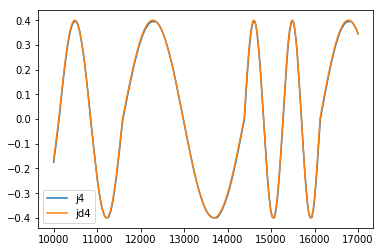

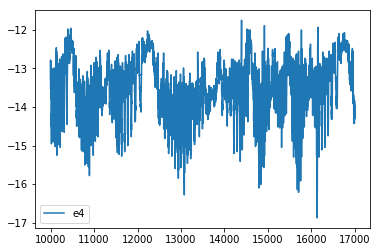

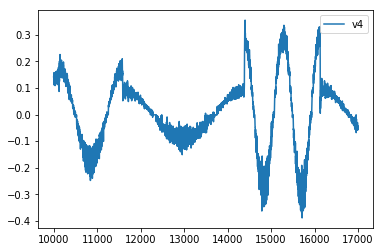

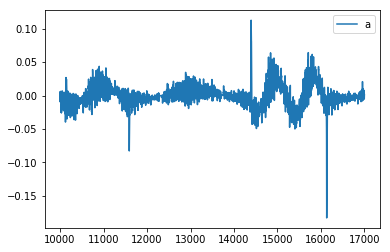

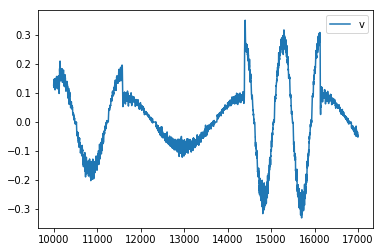

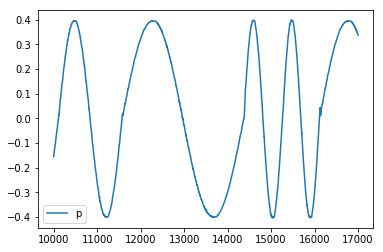

In [16]:

inicio = 10000
final = 17000
fig1 = plt.figure()
joint[inicio:final].plot()
joint_desired[inicio:final].plot(); plt.legend(loc='best')
fig2 = plt.figure(); effort_desired[inicio:final].plot(); plt.legend(loc='best')
fig21 = plt.figure(); velocity[inicio:final].plot(); plt.legend(loc='best')
fig22 = plt.figure(); df['a'][inicio:final].plot(); plt.legend(loc='best')
fig23 = plt.figure(); df['v'][inicio:final].plot(); plt.legend(loc='best')
fig24 = plt.figure(); df['p'][inicio:final].plot(); plt.legend(loc='best')

### Plotting delta rad vs effort

In [17]:
fig4 = plt.figure(); df[inicio:final].plot(x = effort_desired_name, y = 'delta_joint', marker='.',lw=0.05); plt.legend(loc='best')

KeyError: 'delta_joint'

<Figure size 432x288 with 0 Axes>

### Prueba de validación para modelo FFNN
#### Solo Neuronas Lineales (model1)
Se utiliza un modelo de 1 input layer de 15 neuronas lineales, 2 hidden layers de 15 neuronas lineales y 1 output layer de 2 neuronas lineales.  

In [8]:
# Generating model
model1 = Sequential()
model1.add(Dense(units=200, activation='linear', input_dim=4))
model1.add(Dense(units=200, activation='sigmoid'))
model1.add(Dense(units=200, activation='sigmoid'))
model1.add(Dense(units=300, activation='sigmoid'))
model1.add(Dense(units=200, activation='sigmoid'))
model1.add(Dense(units=300, activation='sigmoid'))
model1.add(Dense(units=200, activation='tanh'))
model1.add(Dense(units=100, activation='linear'))
model1.add(Dense(units=1, activation='linear'))

model1.compile(loss='mean_squared_error',
              optimizer='Adam',
              metrics=['accuracy'])

#### Feeding data

In [10]:
model1.fit(x_train, y_train, epochs=10, batch_size=50)

Epoch 1/10
3501/3501 [==============================] - 1s 323us/step - loss: 1.3741e-05 - acc: 2.8563e-04
Epoch 2/10
3501/3501 [==============================] - 1s 296us/step - loss: 2.6183e-05 - acc: 2.8563e-04
Epoch 3/10
3501/3501 [==============================] - 1s 283us/step - loss: 4.4382e-05 - acc: 2.8563e-04
Epoch 4/10
3501/3501 [==============================] - ETA: 0s - loss: 1.0079e-05 - acc: 2.9412e-0 - 1s 283us/step - loss: 1.0629e-05 - acc: 2.8563e-04
Epoch 5/10
3501/3501 [==============================] - 1s 292us/step - loss: 3.7050e-05 - acc: 2.8563e-04
Epoch 6/10
3501/3501 [==============================] - 1s 282us/step - loss: 8.6678e-05 - acc: 2.8563e-04
Epoch 7/10
3501/3501 [==============================] - 1s 280us/step - loss: 1.9108e-04 - acc: 2.8563e-04
Epoch 8/10
3501/3501 [==============================] - 1s 289us/step - loss: 4.1167e-05 - acc: 2.8563e-04
Epoch 9/10
3501/3501 [==============================] - 1s 294us/step - loss: 7.3924e-05 - acc: 2.

In [96]:
y1_pred = model1.predict(x_val)
df_val['y1_pred'] = y1_pred

<Figure size 432x288 with 0 Axes>

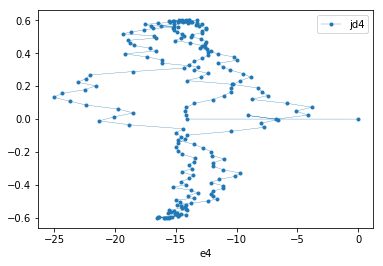

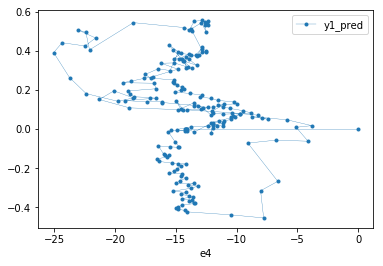

<Figure size 432x288 with 0 Axes>

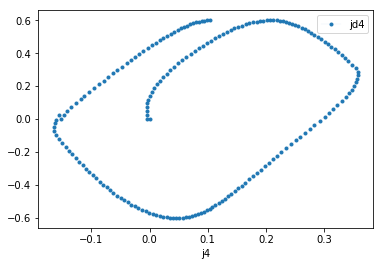

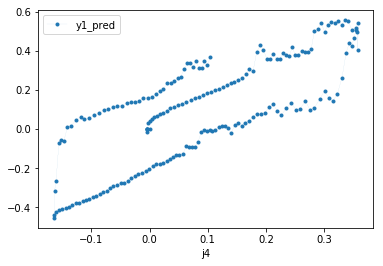

<Figure size 432x288 with 0 Axes>

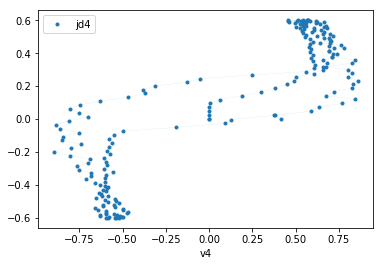

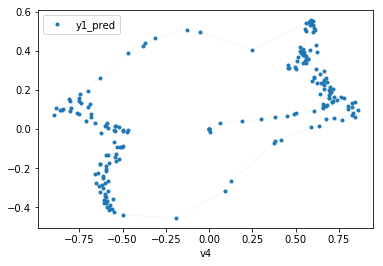

<Figure size 432x288 with 0 Axes>

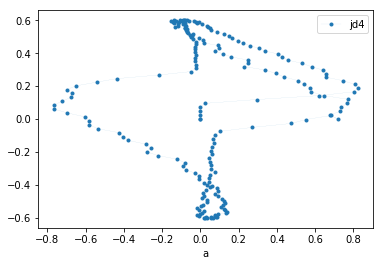

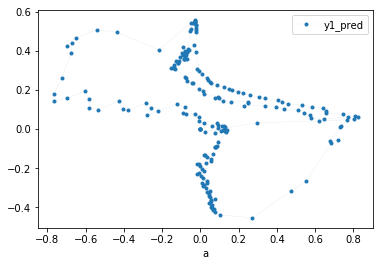

In [97]:
fig5 = plt.figure(); df_val[0:200].plot(x = effort_desired_name, y = joint_desired_name, marker='.',lw=0.3)
df_val[0:200].plot(x = effort_desired_name, y = 'y1_pred', marker='.',lw=0.3); plt.legend(loc='best')

fig6 = plt.figure(); df_val[0:200].plot(x = joint_name, y = joint_desired_name, marker='.',lw=0.05)
df_val[0:200].plot(x = joint_name, y = 'y1_pred', marker='.',lw=0.05); plt.legend(loc='best')

fig6 = plt.figure(); df_val[0:200].plot(x = velocity_name, y = joint_desired_name, marker='.',lw=0.05)
df_val[0:200].plot(x = velocity_name, y = 'y1_pred', marker='.',lw=0.05); plt.legend(loc='best')

fig7 = plt.figure(); df_val[0:200].plot(x = 'a', y = joint_desired_name, marker='.',lw=0.05)
df_val[0:200].plot(x = 'a', y = 'y1_pred', marker='.',lw=0.05); plt.legend(loc='best')

### Neuronas  con función de activación sigmoid
Se utiliza un modelo de 1 input layer de 20 neuronas lineales, 2 hidden layers de 20 neuronas sigmoides y 1 output layer de 2 neuronas lineales.  

In [18]:
model2 = Sequential()
model2.add(Dense(units=40, activation='linear', input_dim=4))
model2.add(Dense(units=40, activation='sigmoid'))
model2.add(Dense(units=40, activation='sigmoid'))
model2.add(Dense(units=1, activation='linear'))

model2.compile(loss='mean_squared_error',
              optimizer='Adam',
              metrics=['accuracy'])


#### Feeding data

In [19]:
model2.fit(x_train, y_train, epochs=10, batch_size=50)

Epoch 1/10
50001/50001 [==============================] - 4s 74us/step - loss: 0.0096 - acc: 2.0000e-05
Epoch 2/10
50001/50001 [==============================] - 3s 57us/step - loss: 2.0664e-05 - acc: 2.0000e-05
Epoch 3/10
50001/50001 [==============================] - 3s 57us/step - loss: 3.1076e-05 - acc: 2.0000e-05
Epoch 4/10
50001/50001 [==============================] - 3s 58us/step - loss: 3.3421e-05 - acc: 2.0000e-05
Epoch 5/10
50001/50001 [==============================] - 3s 63us/step - loss: 3.3628e-05 - acc: 2.0000e-05
Epoch 6/10
50001/50001 [==============================] - 3s 66us/step - loss: 3.2579e-05 - acc: 2.0000e-05
Epoch 7/10
50001/50001 [==============================] - 3s 61us/step - loss: 2.8977e-05 - acc: 2.0000e-05
Epoch 8/10
50001/50001 [==============================] - 3s 59us/step - loss: 2.9039e-05 - acc: 2.0000e-05
Epoch 9/10
50001/50001 [==============================] - 3s 64us/step - loss: 2.7094e-05 - acc: 2.0000e-05
Epoch 10/10
50001/50001 [=======

In [21]:
y2_pred = model2.predict(x_val)

In [22]:
df_val['y2_pred'] = y2_pred

<Figure size 432x288 with 0 Axes>

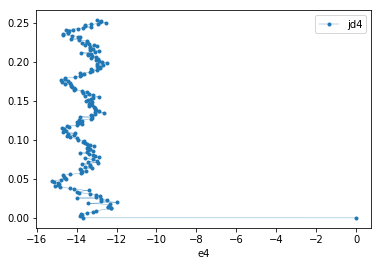

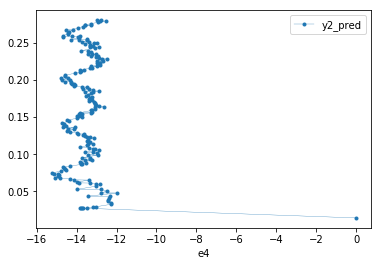

<Figure size 432x288 with 0 Axes>

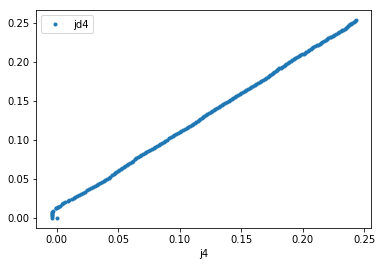

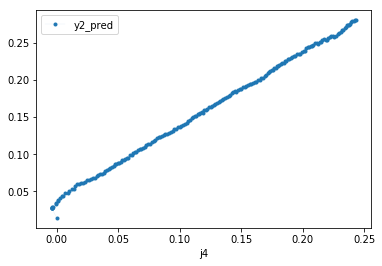

<Figure size 432x288 with 0 Axes>

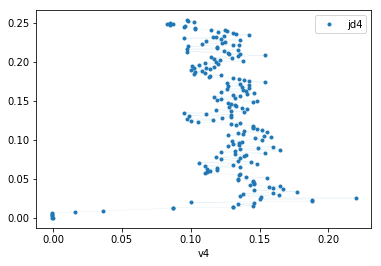

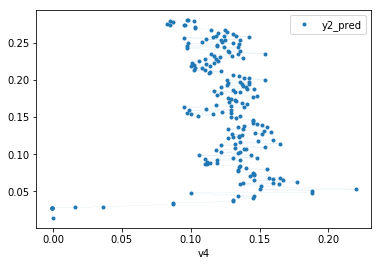

<Figure size 432x288 with 0 Axes>

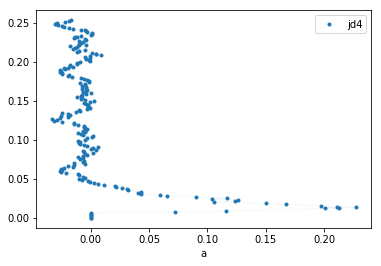

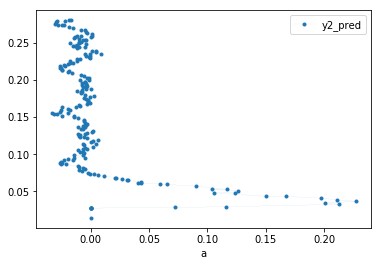

In [23]:
fig8 = plt.figure(); df_val[0:200].plot(x = effort_desired_name, y = joint_desired_name, marker='.',lw=0.3)
df_val[0:200].plot(x = effort_desired_name, y = 'y2_pred', marker='.',lw=0.3); plt.legend(loc='best')

fig9 = plt.figure(); df_val[0:200].plot(x = joint_name, y = joint_desired_name, marker='.',lw=0.05)
df_val[0:200].plot(x = joint_name, y = 'y2_pred', marker='.',lw=0.05); plt.legend(loc='best')

fig10 = plt.figure(); df_val[0:200].plot(x = velocity_name, y = joint_desired_name, marker='.',lw=0.05)
df_val[0:200].plot(x = velocity_name, y = 'y2_pred', marker='.',lw=0.05); plt.legend(loc='best')

fig11 = plt.figure(); df_val[0:200].plot(x = 'a', y = joint_desired_name, marker='.',lw=0.05)
df_val[0:200].plot(x = 'a', y = 'y2_pred', marker='.',lw=0.05); plt.legend(loc='best')

### Neuronas  con función de activación tanh
Se utiliza un modelo de 1 input layer de 20 neuronas lineales, 2 hidden layers de 20 neuronas tanh y 1 output layer de 2 neuronas lineales.  

In [33]:
model3 = Sequential()
model3.add(Dense(units=40, activation='linear', input_dim=4))
model3.add(Dense(units=40, activation='tanh'))
model3.add(Dense(units=40, activation='tanh'))
model3.add(Dense(units=1, activation='linear'))

model3.compile(loss='mean_squared_error',
              optimizer='Adam',
              metrics=['accuracy'])


In [34]:
model3.fit(x_train, y_train, epochs=10, batch_size=50)

Epoch 1/10
3501/3501 [==============================] - 1s 178us/step - loss: 0.0884 - acc: 2.8563e-04
Epoch 2/10
3501/3501 [==============================] - 0s 77us/step - loss: 5.1795e-04 - acc: 2.8563e-04
Epoch 3/10
3501/3501 [==============================] - 0s 87us/step - loss: 1.3202e-04 - acc: 2.8563e-04
Epoch 4/10
3501/3501 [==============================] - 0s 81us/step - loss: 6.6688e-05 - acc: 2.8563e-04
Epoch 5/10
3501/3501 [==============================] - 0s 84us/step - loss: 3.3618e-05 - acc: 2.8563e-04
Epoch 6/10
3501/3501 [==============================] - 0s 74us/step - loss: 3.3077e-05 - acc: 2.8563e-04
Epoch 7/10
3501/3501 [==============================] - 0s 80us/step - loss: 1.0650e-04 - acc: 2.8563e-04
Epoch 8/10
3501/3501 [==============================] - 0s 84us/step - loss: 2.5765e-05 - acc: 2.8563e-04
Epoch 9/10
3501/3501 [==============================] - 0s 75us/step - loss: 1.9046e-05 - acc: 2.8563e-04
Epoch 10/10
3501/3501 [==========================

In [35]:
y3_pred = model3.predict(x_val)
df_val['y3_pred'] = y3_pred


<Figure size 432x288 with 0 Axes>

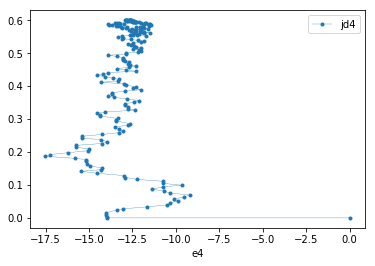

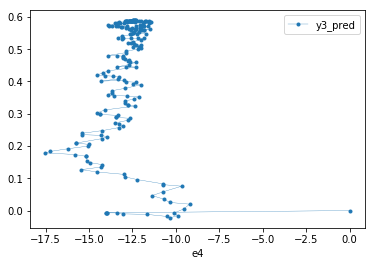

<Figure size 432x288 with 0 Axes>

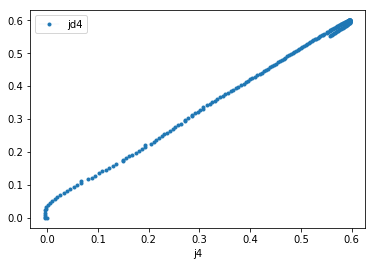

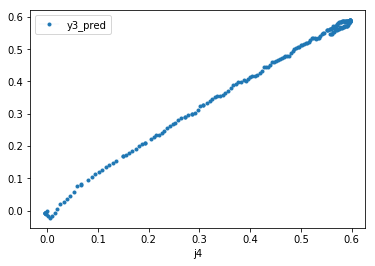

<Figure size 432x288 with 0 Axes>

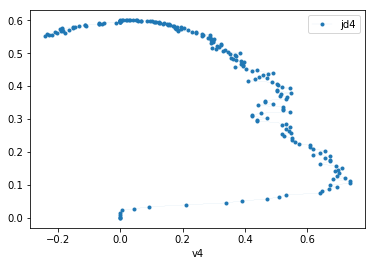

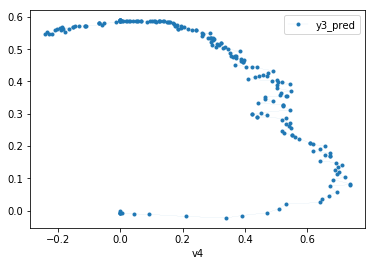

In [36]:
fig11 = plt.figure(); df_val[0:200].plot(x = effort_desired_name, y = joint_desired_name, marker='.',lw=0.3)
df_val[0:200].plot(x = effort_desired_name, y = 'y3_pred', marker='.',lw=0.3); plt.legend(loc='best')

fig12 = plt.figure(); df_val[0:200].plot(x = joint_name, y = joint_desired_name, marker='.',lw=0.05)
df_val[0:200].plot(x = joint_name, y = 'y3_pred', marker='.',lw=0.05); plt.legend(loc='best')

fig13 = plt.figure(); df_val[0:200].plot(x = velocity_name, y = joint_desired_name, marker='.',lw=0.05)
df_val[0:200].plot(x = velocity_name, y = 'y3_pred', marker='.',lw=0.05); plt.legend(loc='best')

### Neuronas  con función de activación elu (model 4)
Se utiliza un modelo de 1 input layer de 20 neuronas lineales, 2 hidden layers de 20 neuronas elu y 1 output layer de 2 neuronas lineales.  

In [35]:
model4 = Sequential()
model4.add(Dense(units=40, activation='linear', input_dim=4))
model4.add(Dense(units=40, activation='elu'))
model4.add(Dense(units=40, activation='elu'))
model4.add(Dense(units=1, activation='linear'))

model4.compile(loss='mean_squared_error',
              optimizer='Adam',
              metrics=['accuracy'])

In [39]:
model4.fit(x_train, y_train, epochs=10, batch_size=50)

Epoch 1/10
50001/50001 [==============================] - 4s 70us/step - loss: 7.2572e-05 - acc: 2.0000e-05
Epoch 2/10
50001/50001 [==============================] - 3s 69us/step - loss: 7.4741e-05 - acc: 2.0000e-05
Epoch 3/10
50001/50001 [==============================] - 3s 70us/step - loss: 6.1651e-05 - acc: 2.0000e-05
Epoch 4/10
50001/50001 [==============================] - 3s 70us/step - loss: 5.1053e-05 - acc: 2.0000e-05
Epoch 5/10
50001/50001 [==============================] - 4s 72us/step - loss: 4.8437e-05 - acc: 2.0000e-05
Epoch 6/10
50001/50001 [==============================] - 4s 71us/step - loss: 7.7801e-05 - acc: 2.0000e-05
Epoch 7/10
50001/50001 [==============================] - 4s 73us/step - loss: 3.9469e-05 - acc: 2.0000e-05
Epoch 8/10
50001/50001 [==============================] - 4s 70us/step - loss: 3.5126e-05 - acc: 2.0000e-05
Epoch 9/10
50001/50001 [==============================] - 3s 70us/step - loss: 3.6939e-05 - acc: 2.0000e-05
Epoch 10/10
50001/50001 [===

In [40]:
y4_pred = model4.predict(x_val)
df_val['y4_pred'] = y4_pred


<Figure size 432x288 with 0 Axes>

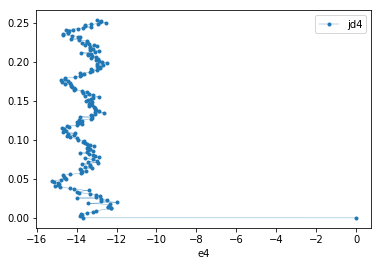

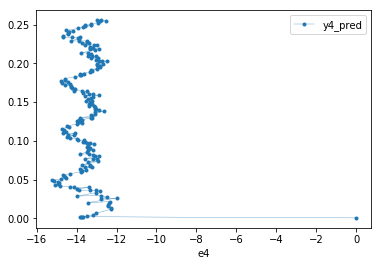

<Figure size 432x288 with 0 Axes>

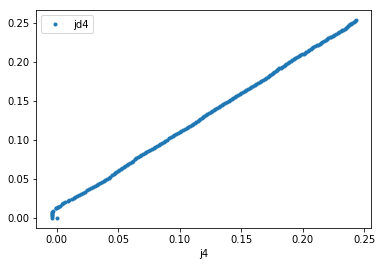

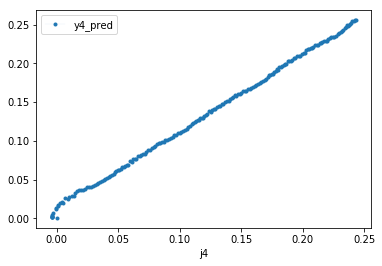

<Figure size 432x288 with 0 Axes>

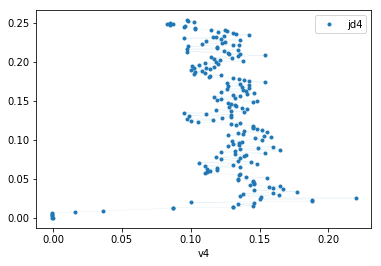

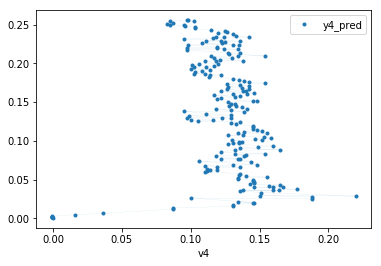

In [41]:
fig14 = plt.figure(); df_val[0:200].plot(x = effort_desired_name, y = joint_desired_name, marker='.',lw=0.3)
df_val[0:200].plot(x = effort_desired_name, y = 'y4_pred', marker='.',lw=0.3); plt.legend(loc='best')

fig15 = plt.figure(); df_val[0:200].plot(x = joint_name, y = joint_desired_name, marker='.',lw=0.05)
df_val[0:200].plot(x = joint_name, y = 'y4_pred', marker='.',lw=0.05); plt.legend(loc='best')

fig16 = plt.figure(); df_val[0:200].plot(x = velocity_name, y = joint_desired_name, marker='.',lw=0.05)
df_val[0:200].plot(x = velocity_name, y = 'y4_pred', marker='.',lw=0.05); plt.legend(loc='best')

In [42]:
from keras.models import load_model
model4.save('my_model.h5') 

### Neuronas  con función de activación LeakyReLU (model 5)
Se utiliza un modelo de 1 input layer de 20 neuronas lineales, 2 hidden layers de 20 neuronas LeakyReLU y 1 output layer de 2 neuronas lineales.  

In [26]:
model5 = Sequential()
model5.add(Dense(units=40, activation='linear', input_dim=4))
model5.add(Dense(units=40, activation=LeakyReLU(alpha=0.3)))
model5.add(Dense(units=40, activation=LeakyReLU(alpha=0.3)))
model5.add(Dense(units=1, activation='linear'))

model5.compile(loss='mean_squared_error',
              optimizer='Adam',
              metrics=['accuracy'])

In [27]:
model5.fit(x_train, y_train, epochs=10, batch_size=50)

Epoch 1/10
50001/50001 [==============================] - 4s 83us/step - loss: 0.0085 - acc: 2.0000e-05
Epoch 2/10
50001/50001 [==============================] - 4s 74us/step - loss: 7.9682e-06 - acc: 2.0000e-05
Epoch 3/10
50001/50001 [==============================] - 3s 69us/step - loss: 4.5877e-05 - acc: 2.0000e-05
Epoch 4/10
50001/50001 [==============================] - 4s 70us/step - loss: 1.6003e-04 - acc: 2.0000e-05
Epoch 5/10
50001/50001 [==============================] - 3s 69us/step - loss: 1.4294e-04 - acc: 2.0000e-05
Epoch 6/10
50001/50001 [==============================] - 4s 71us/step - loss: 1.2341e-04 - acc: 2.0000e-05
Epoch 7/10
50001/50001 [==============================] - 3s 68us/step - loss: 1.0612e-04 - acc: 2.0000e-05
Epoch 8/10
50001/50001 [==============================] - 3s 68us/step - loss: 7.5434e-05 - acc: 2.0000e-05
Epoch 9/10
50001/50001 [==============================] - 4s 71us/step - loss: 8.5594e-05 - acc: 2.0000e-05
Epoch 10/10
50001/50001 [=======

In [28]:
y5_pred = model5.predict(x_val)
df_val['y5_pred'] = y5_pred


<Figure size 432x288 with 0 Axes>

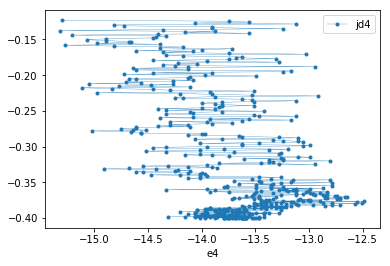

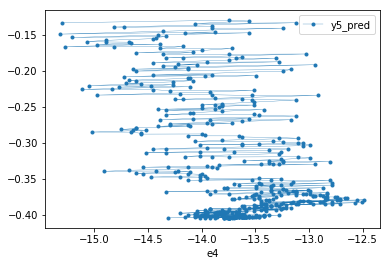

<Figure size 432x288 with 0 Axes>

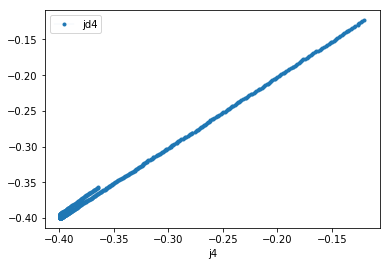

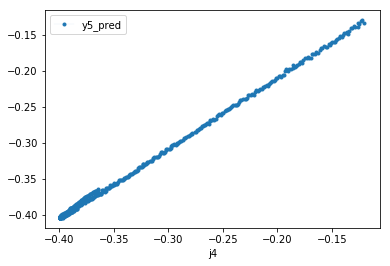

<Figure size 432x288 with 0 Axes>

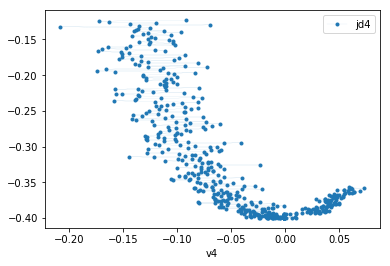

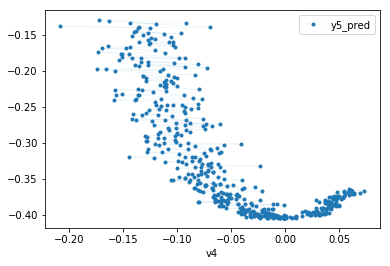

In [31]:
fig19 = plt.figure(); df_val[1000:1500].plot(x = effort_desired_name, y = joint_desired_name, marker='.',lw=0.3)
df_val[1000:1500].plot(x = effort_desired_name, y = 'y5_pred', marker='.',lw=0.3); plt.legend(loc='best')

fig20 = plt.figure(); df_val[1000:1500].plot(x = joint_name, y = joint_desired_name, marker='.',lw=0.05)
df_val[1000:1500].plot(x = joint_name, y = 'y5_pred', marker='.',lw=0.05); plt.legend(loc='best')

fig21 = plt.figure(); df_val[1000:1500].plot(x = velocity_name, y = joint_desired_name, marker='.',lw=0.05)
df_val[1000:1500].plot(x = velocity_name, y = 'y5_pred', marker='.',lw=0.05); plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

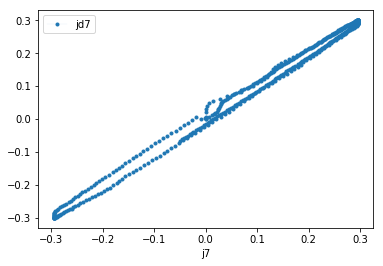

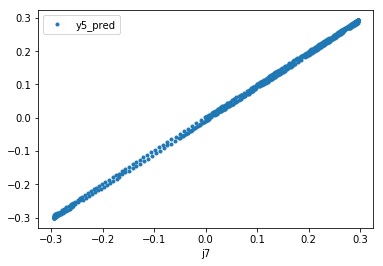

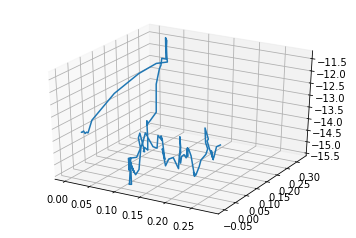

In [136]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(df_val['jd4'][1:100],df_val['a'][1:100], zs = df_val['e4'][1:100])

AttributeError: 'LeakyReLU' object has no attribute '__name__'

In [81]:
model4.predict(np.array([[0.6, 0.1, 0.1, -1.1,]]))#(x_val[0:1])

array([[0.7431776]], dtype=float32)

In [80]:
print x_val[0:1].shape
print np.array([0.1, 0.1, 0.1, 0.1,]).shape

(1, 4)
(4,)
